In [74]:
#Import required Libraries
import pandas as pd
from time import strftime
import datetime
import numpy as np
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, ExtraTreesRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import explained_variance_score
import pylab as plt
%matplotlib inline

In [75]:
#Load spreadsheet
file = '/Users/natashasharma/Downloads/WindPowerForecastingDataTASK.xlsx'
spreadsheet = pd.ExcelFile(file)

# Print the sheet names
print(spreadsheet.sheet_names)


[u'WindPowerForecastingData']


In [76]:
# Load a sheet into a DataFrame
dataframe1 = spreadsheet.parse('WindPowerForecastingData')
#dataframe1 = dataframe.dropna()
#print dataframe1
#dataframe1.dropna(inplace=True)
#dataframe1.reset_index(drop=True, inplace=True)
#print dataframe1

In [77]:
# Create a new Dataframe with required data to predict wind power output
#print dataframe1
columns = ['U10', 'V10', 'U100','V100','year','day','month','hour']
index = np.arange(len(dataframe1.index))
dataframe2 = pd.DataFrame(columns=columns, index = index)

# Convert timestamp into datetime format - Wind power might depends on the month of the year and time of the day
dataframe1["date"] = pd.to_datetime(dataframe1["TIMESTAMP"])

#Insert data into dataframe2 for output prediction purpose
dataframe2["year"] = dataframe1['date'].apply(lambda x: x.year)
dataframe2["month"] = dataframe1['date'].apply(lambda x: x.month)
dataframe2["day"] = dataframe1['date'].apply(lambda x: x.timetuple().tm_yday)
dataframe2["hour"] = dataframe1['date'].apply(lambda x: x.hour)

# Copy wind velocity data
dataframe2["U10"] = dataframe1["U10"]
dataframe2["V10"] = dataframe1["V10"]
dataframe2["U100"] = dataframe1["U100"]
dataframe2["V100"] = dataframe1["V100"]

#print dataframe2
#print dataframe2

#Total records in dataframe1
total_n = len(dataframe1.index)

In [29]:
dataframe1["TARGETVAR"].fillna(0, inplace=True)
#d = dataframe1.dropna()

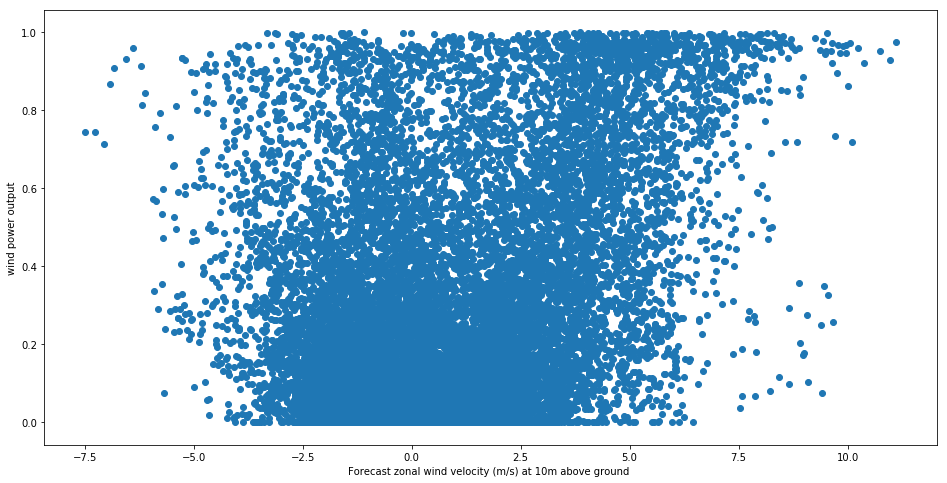

In [53]:
# Forecast zonal wind velocity at 10m above v/s wind power output
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dataframe2['U10'].head(total_n - 24), dataframe1["TARGETVAR"].head(total_n - 24))
ax.set_xlabel('Forecast zonal wind velocity (m/s) at 10m above ground ')
ax.set_ylabel('wind power output')
plt.show()

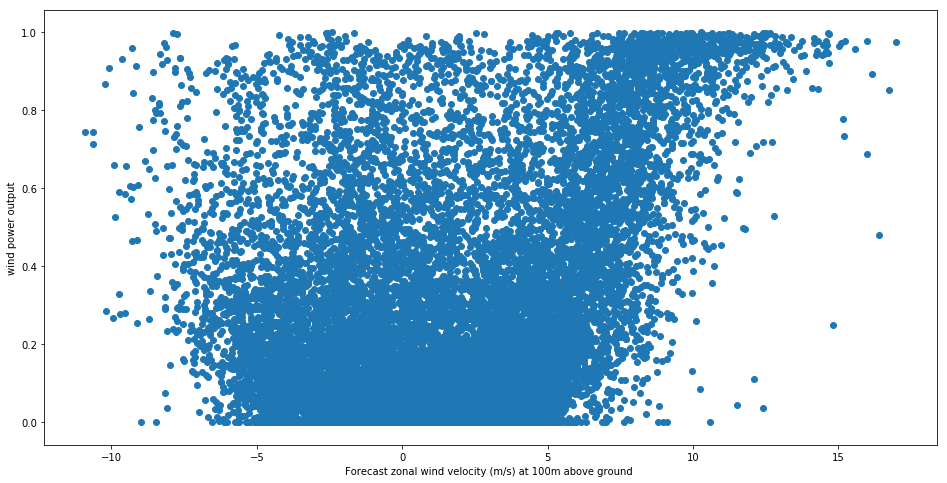

In [31]:
# Forecast zonal wind velocity at 100m above  v/s wind power output
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dataframe2['U100'].head(total_n - 24), dataframe1["TARGETVAR"].head(total_n - 24))
ax.set_xlabel('Forecast zonal wind velocity (m/s) at 100m above ground ')
ax.set_ylabel('wind power output')
plt.show()

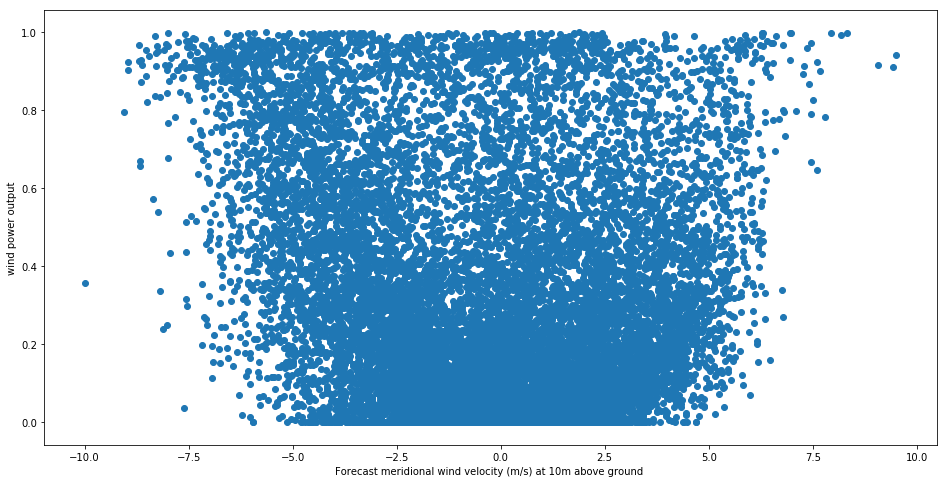

In [32]:
# Forecast meridional wind velocity at 10m above v/s wind power output
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dataframe2['V10'].head(total_n - 24), dataframe1["TARGETVAR"].head(total_n - 24))
ax.set_xlabel('Forecast meridional wind velocity (m/s) at 10m above ground ')
ax.set_ylabel('wind power output')
plt.show()

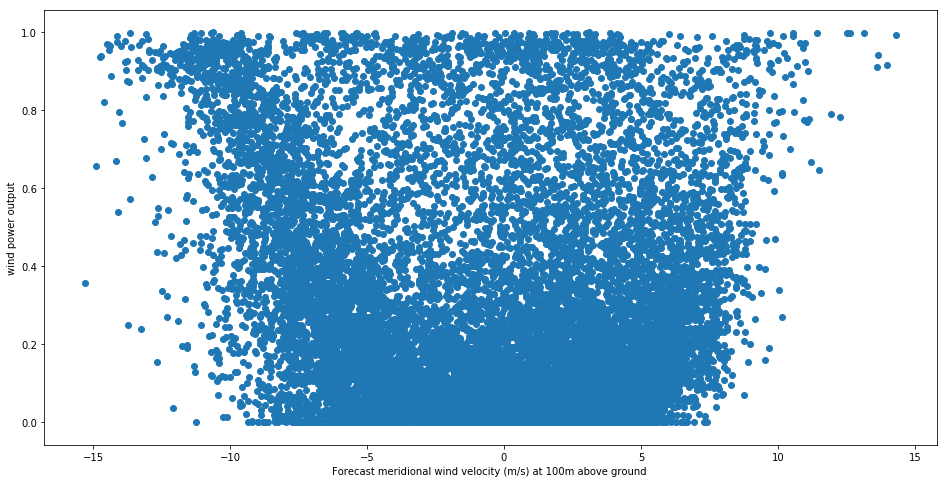

In [33]:
# Forecast meridional wind velocity at 100m above v/s wind power output
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dataframe2['V100'].head(total_n - 24), dataframe1["TARGETVAR"].head(total_n - 24))
ax.set_xlabel('Forecast meridional wind velocity (m/s) at 100m above ground ')
ax.set_ylabel('wind power output')
plt.show()

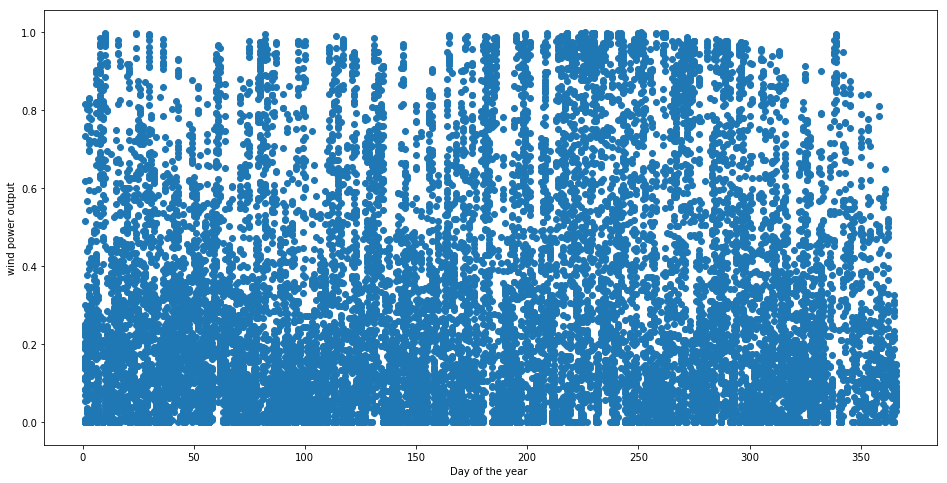

In [34]:
# day v/s wind power output
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dataframe2['day'].head(total_n - 24), dataframe1["TARGETVAR"].head(total_n - 24))
ax.set_xlabel('Day of the year ')
ax.set_ylabel('wind power output')
plt.show()

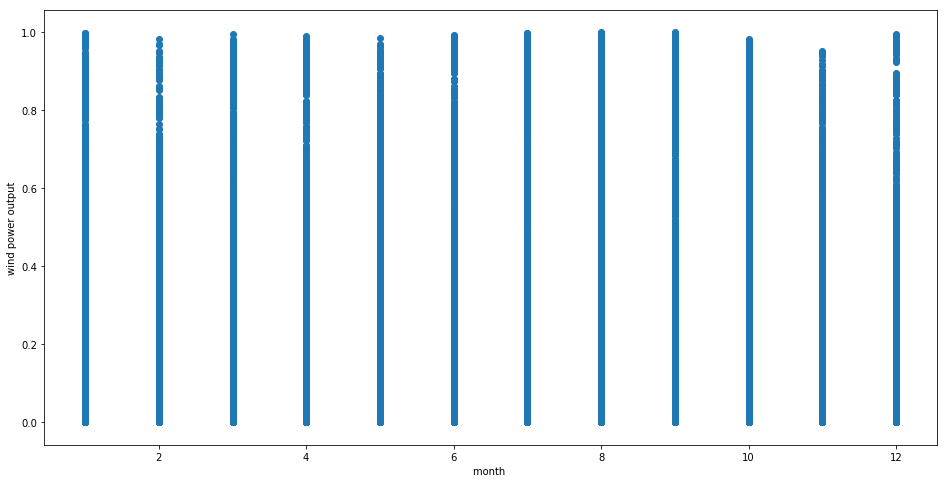

In [35]:
# month v/s wind power output
fig, ax = plt.subplots(figsize=(16,8))
ax.scatter(dataframe2['month'].head(total_n - 24), dataframe1["TARGETVAR"].head(total_n - 24))
ax.set_xlabel('month ')
ax.set_ylabel('wind power output')
plt.show()

In [65]:
#Split the data where wind power output is known, into train and test
# this will allow to predict the missing wind power by training and 
# testing the available data and finding the accuracy of used model

X_train, X_test, Y_train, Y_test  = train_test_split((dataframe2.head(total_n - 24)).values,
                      (dataframe1["TARGETVAR"].head(total_n - 24)).values, 
                      test_size=0.4, random_state=0)

In [66]:
# Create a random forest regressor
clf = ExtraTreesRegressor(n_estimators=5000)

# Train the regressor
clf.fit(X_train, Y_train)

# Print the name and importance of each feature
for feature in zip(columns, clf.feature_importances_):
    print(feature)

('U10', 0.19197314540446711)
('V10', 0.14949951471857231)
('U100', 0.26857382310580424)
('V100', 0.19284523370574627)
('year', 0.023711758174531049)
('day', 0.057420697076408803)
('month', 0.04478761087566651)
('hour', 0.071188216938804394)


In [67]:
# Select best features 
sfm = SelectFromModel(clf, threshold=0.10)

# Train the selector
sfm.fit(X_train, Y_train)

for feature_list_index in sfm.get_support(indices=True):
    print(columns[feature_list_index])
    
# Transform the train and test data
X_train_new = sfm.transform(X_train)
X_test_new = sfm.transform(X_test)

U10
V10
U100
V100


In [68]:
# Create a new random forest Regressor for the most important features
clf_important = ExtraTreesRegressor(n_estimators=5000)

# Train the new Regressor on the new dataset containing the most important features
clf_important.fit(X_train_new, Y_train)

ExtraTreesRegressor(bootstrap=False, criterion='mse', max_depth=None,
          max_features='auto', max_leaf_nodes=None,
          min_impurity_split=1e-07, min_samples_leaf=1,
          min_samples_split=2, min_weight_fraction_leaf=0.0,
          n_estimators=5000, n_jobs=1, oob_score=False, random_state=None,
          verbose=0, warm_start=False)

In [69]:
# Full Featured Regressor v/s Impotant Featured Regressor 


#Step 1 --> Apply The Full Featured Regressor To The Test Data
y_pred = clf.predict(X_test)

#Step 2 -->  View The Accuracy Of Our Full Feature (8 Features) Model
full_feature_pred_score = explained_variance_score(Y_test, y_pred)

#Step 3 --> Apply The Impotant Featured Regressor To The Test Data
y_important_pred = clf_important.predict(X_test_new)

#Step 4 --> View The Accuracy Of Our Impotant Feature (2 Features) Model
imp_feature_pred_score = explained_variance_score(Y_test, y_important_pred)

In [70]:
print full_feature_pred_score
print imp_feature_pred_score

0.76413303208
0.636563142923


In [71]:
# Use model which has highest explained_variance_score to predict missing TARGETVAR

X_unknown_TARGETVAR = dataframe2.tail(24)
predict_unknown_TARGETVAR = clf.predict(X_unknown_TARGETVAR)
print predict_unknown_TARGETVAR

[ 0.26932277  0.24098426  0.37464635  0.42622148  0.44133752  0.42302487
  0.33459016  0.31833206  0.25249967  0.20070426  0.1676294   0.12590151
  0.11638414  0.10336494  0.0925937   0.11461293  0.1359375   0.14722897
  0.17259067  0.15159459  0.24104864  0.26328571  0.22990336  0.15541561]


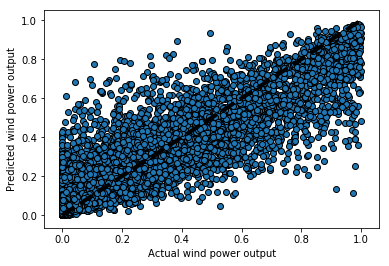

In [72]:
fig, ax = plt.subplots()
ax.scatter(Y_test, y_pred, edgecolors=(0, 0, 0))
ax.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'k--', lw=4)
ax.set_xlabel('Actual wind power output')
ax.set_ylabel('Predicted wind power output')
plt.show()

In [73]:
# Check the level of error in the model
mse = sklearn.metrics.mean_squared_error(Y_test, y_pred)
print(mse)

0.0202261082009


In [45]:
print Y_test
print y_pred

[ 0.12921718  0.09848698  0.92087207 ...,  0.91457568  0.3271309
  0.15111362]
[ 0.26212681  0.13187313  0.84368338 ...,  0.74164972  0.68494469
  0.13469363]


In [46]:
print dataframe2.tail(24)

            U10       V10      U100      V100  year  day  month  hour
16776 -2.695560  1.204642 -3.581017  1.507665  2013  334     11     1
16777 -2.590272  1.081529 -3.420896  1.317269  2013  334     11     2
16778 -2.544634  0.980526 -3.350945  1.175278  2013  334     11     3
16779 -2.405717  0.823745 -3.156395  0.952611  2013  334     11     4
16780 -2.450555  0.770479 -3.213230  0.888715  2013  334     11     5
16781 -2.644717  0.806157 -3.512160  0.956484  2013  334     11     6
16782 -2.890523  0.803142 -3.953177  0.982945  2013  334     11     7
16783 -2.647119  0.616211 -4.324789  0.867417  2013  334     11     8
16784 -1.817625  0.507168 -4.875104  0.984236  2013  334     11     9
16785 -2.320846  0.757917 -6.106345  1.495402  2013  334     11    10
16786 -2.610689  0.619226 -7.407537  1.448932  2013  334     11    11
16787 -2.404917  0.256921 -6.792736  0.269120  2013  334     11    12
16788 -2.333657  0.132300 -6.263734 -0.392427  2013  334     11    13
16789 -2.330054  0.0